<a id='top'></a> 
# Healthcare Provider Fraud Detection 

#### Table of Contents
- [Background](#background)
- [Data Import](#import)
- [Exploratory Analysis](#eda)
    - [Missingness](#missing)
    - [Fraudulance Prevelance](#fraud)
- [Data Cleaning](#clean)
- [Data Preparation](#prep)
- [Modeling](#model)



## Background <a id='background'></a>

[Kaggle Compitition](https://www.kaggle.com/rohitrox/healthcare-provider-fraud-detection-analysis)

[example](https://www.kaggle.com/rohitrox/medical-provider-fraud-detection/log)



[How to spot fraud](https://www.medicare.gov/forms-help-resources/help-fight-medicare-fraud/how-spot-medicare-fraud)
[Common fraud techniques](http://blog.joinvanderbilt.com/spot-common-types-of-medicare-fraud)



## Questions for Carolina
1. How do diagnosis / procedure codes work?
2. Claims start or end different than admit/discharge. 


# TO DO:
1. diag/proc code ratio as feature. 
2. diag & proc code interpretations

## Data Import <a id='import'></a>

[Back To Top](#top)

In [1]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
import missingno as msno
import apyori as apriori

In [2]:
file_list = ["Test-1542969243754.csv",
             "Test_Beneficiarydata-1542969243754.csv",
             "Test_Inpatientdata-1542969243754.csv",
             "Test_Outpatientdata-1542969243754.csv",
             "Train-1542865627584.csv",
             "Train_Beneficiarydata-1542865627584.csv",
             "Train_Inpatientdata-1542865627584.csv",
             "Train_Outpatientdata-1542865627584.csv"]

clean = str.maketrans("","","-0123456789")
file_names = [x.translate(clean).replace(".csv","") for x in file_list]


def custom_import(train_only = False):
    '''
    
    '''
    
    name_file_dict = dict()
    PATH          = "./data/"
    
    for name, file in zip(file_names,file_list):
        name_file_dict[name] = pd.read_csv(PATH+file)

    if train_only:
        return_dict = {key: value for key, value in name_file_dict.items() if key.startswith("Train")}
        return return_dict
    else:
        return name_file_dict
    
        
    
data_dict = custom_import(train_only=False)

In [3]:
prov_key = data_dict['Train']
prov_key = prov_key.replace({"No":0,"Yes":1})

Bene_data = data_dict['Train_Beneficiarydata']

dfs = [data_dict['Train_Inpatientdata'],data_dict['Train_Outpatientdata']]
keys = ['Inpatient',"Outpatient"]
Train_Patientdata = pd.concat([df.assign(Source=key).reset_index() for key, df in zip(keys,dfs)],axis=0, ignore_index=True).drop('index',axis=1)

claims = Train_Patientdata.merge(Bene_data,on="BeneID")
claims = claims.merge(prov_key,on='Provider')

## Exploratory Analysis <a id='eda'></a>

[Back To Top](#top)

Provider Data

In [8]:
prov_key

,Provider,PotentialFraud
0,PRV51001,0
1,PRV51003,1
2,PRV51004,0
3,PRV51005,1
4,PRV51007,0
...,...,...
5405,PRV57759,0
5406,PRV57760,0
5407,PRV57761,0
5408,PRV57762,0


In [10]:
print("Provider Key Information")
print("-"*30)
print("Number of unique Providers: {}\n".format(prov_key.Provider.nunique()))
print("Fraud counts: \n{}\n".format(prov_key.PotentialFraud.value_counts()))
fraud_counts = data_dict['Train'].PotentialFraud.value_counts()[1]
print("Percent Potential Fraud: {:.3}\n".format(100* fraud_counts/ prov_key.PotentialFraud.count()))

Provider Key Information
------------------------------
Number of unique Providers: 5410

Fraud counts: 
0    4904
1     506
Name: PotentialFraud, dtype: int64

Percent Potential Fraud: 9.35



## Missing Data <a id='missing'></a>

Most missing data is intentional in our dataset. The beneficiary data includes only 1 feature with missingness, DOD (Date of Death), which is a great thing for the patients. 

Inpatient and Outpatiend data sets have a large degree of missingness built into the feature-space. Information about Physicians and Claims is incomplete when there was not a needed service. Interestingly the only missingness not explained by the feature is 899 DeductableAmtPaid values in the Inpatient data. This column has no missingness in the outpatient dataset. 

Missing Features & Count
 Series([], dtype: int64)


<AxesSubplot:>

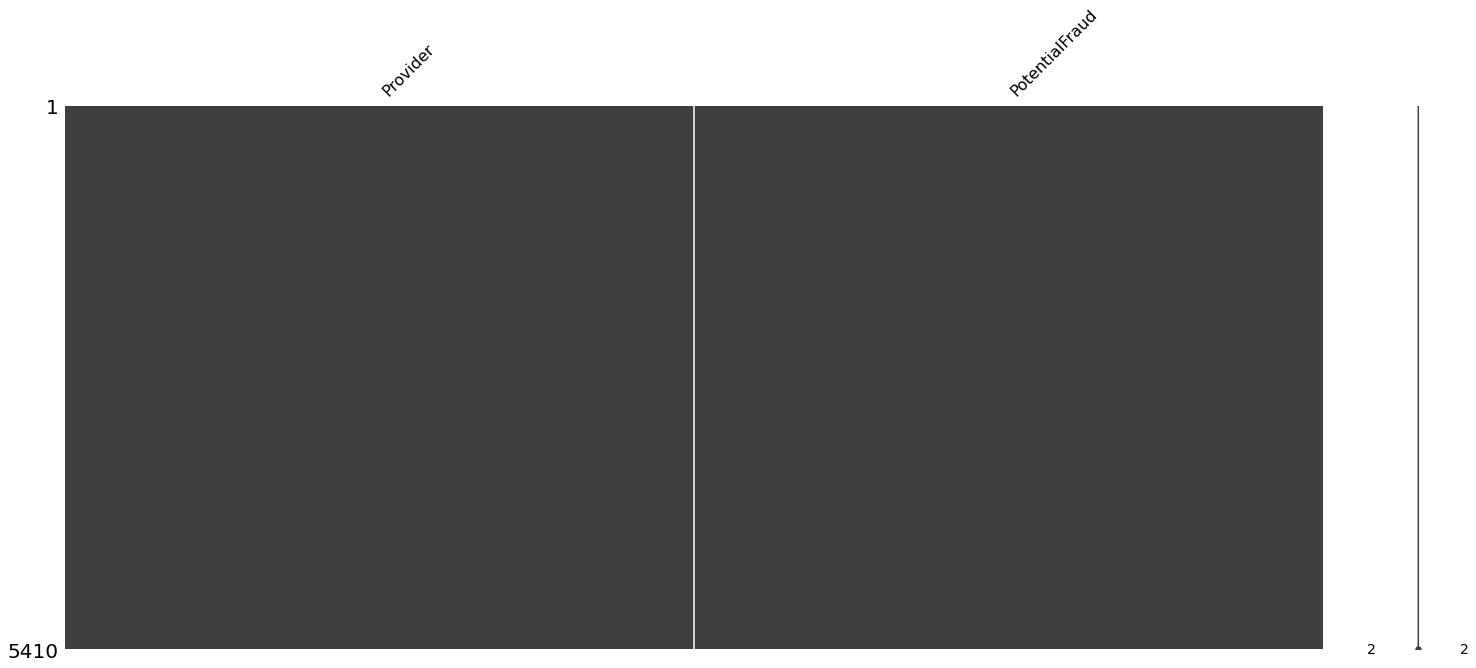

In [78]:
missing = data_dict['Train'].isna().sum(axis=0).sort_values(ascending=False)
print("Missing Features & Count\n",missing[missing!=0])
fig = msno.matrix(data_dict['Train'])
fig_copy = fig.get_figure()
fig_copy.savefig('./graphics/msno_provider.png')
fig

Missing Features & Count
 DOD    137135
dtype: int64


<AxesSubplot:>

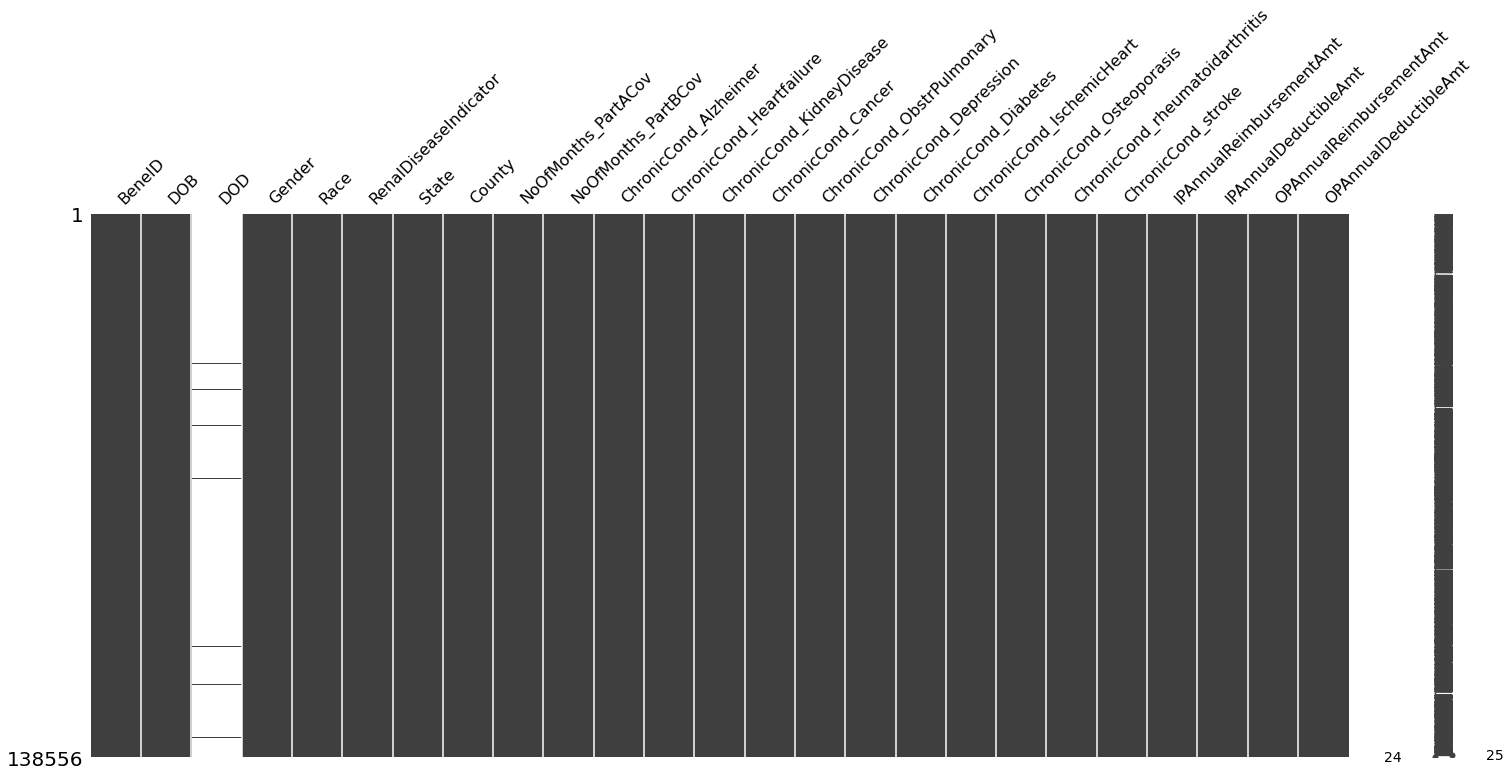

In [79]:
missing = data_dict['Train_Beneficiarydata'].isna().sum(axis=0).sort_values(ascending=False)
print("Missing Features & Count\n",missing[missing!=0])
fig = msno.matrix(data_dict['Train_Beneficiarydata'])
fig_copy = fig.get_figure()
fig_copy.savefig('./graphics/missing_bene.png')
fig

Missing Features & Count
 ClmProcedureCode_6     40474
ClmProcedureCode_5     40465
ClmProcedureCode_4     40358
ClmProcedureCode_3     39509
ClmDiagnosisCode_10    36547
OtherPhysician         35784
ClmProcedureCode_2     35020
ClmProcedureCode_1     17326
OperatingPhysician     16644
ClmDiagnosisCode_9     13497
ClmDiagnosisCode_8      9942
ClmDiagnosisCode_7      7258
ClmDiagnosisCode_6      4838
ClmDiagnosisCode_5      2894
ClmDiagnosisCode_4      1534
DeductibleAmtPaid        899
ClmDiagnosisCode_3       676
ClmDiagnosisCode_2       226
AttendingPhysician       112
dtype: int64


<AxesSubplot:>

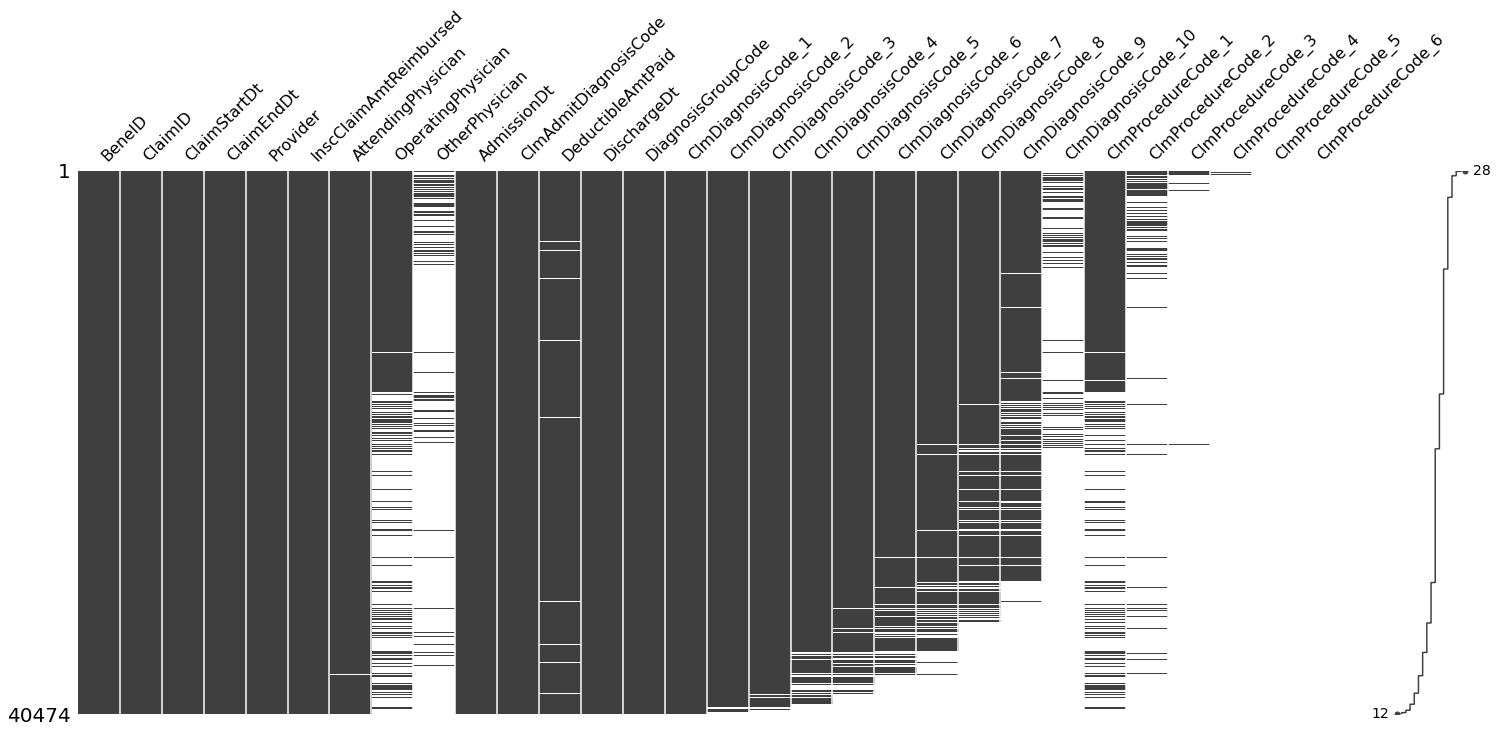

In [80]:
missing = data_dict['Train_Inpatientdata'].isna().sum(axis=0).sort_values(ascending=False)
print("Missing Features & Count\n",missing[missing!=0])
fig = msno.matrix(msno.nullity_sort(data_dict['Train_Inpatientdata'],sort='descending'))
fig_copy = fig.get_figure()
fig_copy.savefig('./graphics/missing_inpat.png')
fig

Missing Features & Count
 ClmProcedureCode_6       517737
ClmProcedureCode_5       517737
ClmProcedureCode_4       517735
ClmProcedureCode_3       517733
ClmProcedureCode_2       517701
ClmProcedureCode_1       517575
ClmDiagnosisCode_10      516654
ClmDiagnosisCode_9       502899
ClmDiagnosisCode_8       494825
ClmDiagnosisCode_7       484776
ClmDiagnosisCode_6       468981
ClmDiagnosisCode_5       443393
OperatingPhysician       427120
ClmAdmitDiagnosisCode    412312
ClmDiagnosisCode_4       392141
OtherPhysician           322691
ClmDiagnosisCode_3       314480
ClmDiagnosisCode_2       195380
ClmDiagnosisCode_1        10453
AttendingPhysician         1396
dtype: int64


<AxesSubplot:>

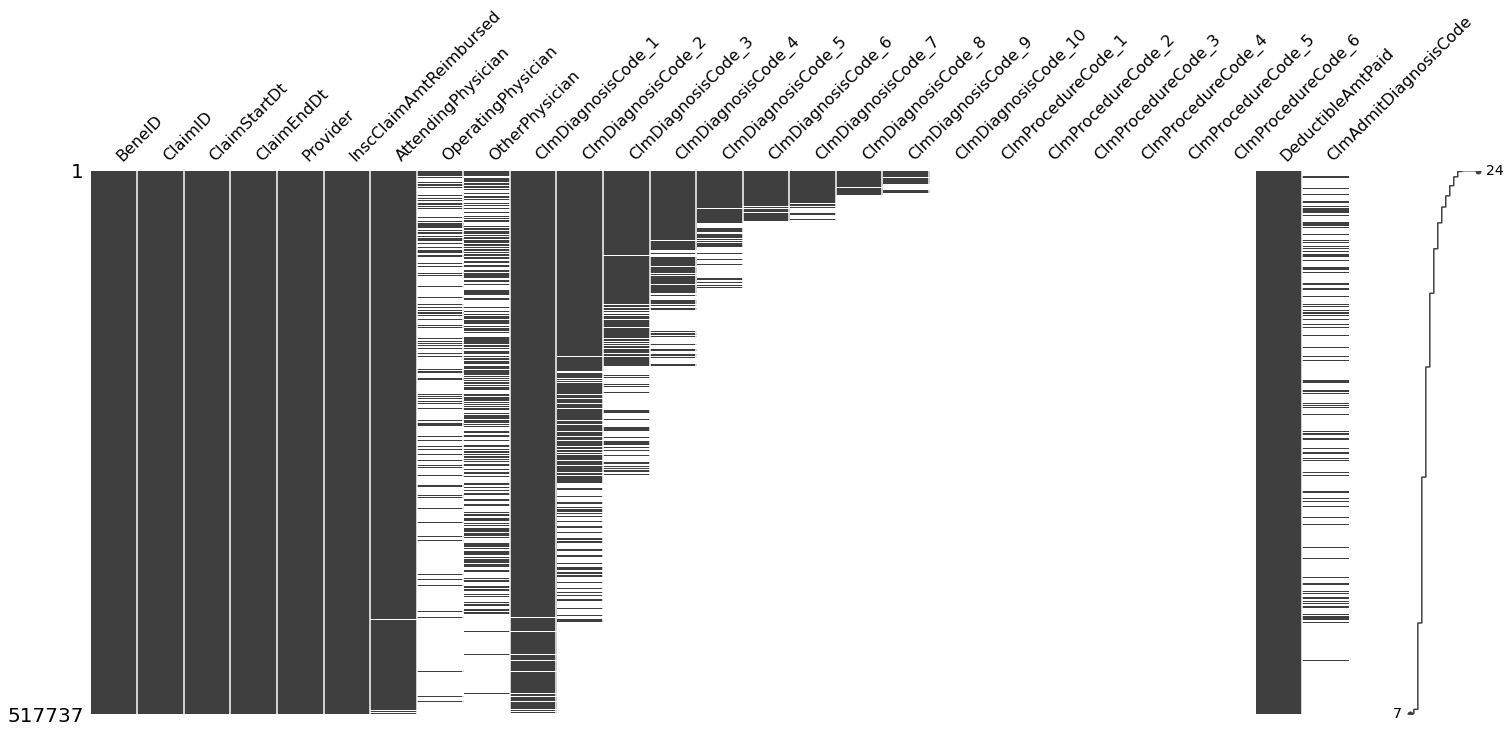

In [81]:
missing = data_dict['Train_Outpatientdata'].isna().sum(axis=0).sort_values(ascending=False)
print("Missing Features & Count\n",missing[missing!=0])
fig = msno.matrix(msno.nullity_sort(data_dict['Train_Outpatientdata'],sort='descending'))
fig_copy = fig.get_figure()
fig_copy.savefig('./graphics/missing_outpat.png')
fig

## Fraudulent providers are overrepresenDeductibleAmtPaided in claims data <a id='fraud'></a>

In [51]:
print("Percent Suspect claims\n",100*claims.PotentialFraud.value_counts()/claims.shape[0])
print("Percent Suspect Providers\n",100*data_dict['Train'].PotentialFraud.value_counts()/data_dict['Train'].shape[0])


Percent Suspect claims
 0    61.878931
1    38.121069
Name: PotentialFraud, dtype: float64
Percent Suspect Providers
 No     90.64695
Yes     9.35305
Name: PotentialFraud, dtype: float64


<ipython-input-82-20bcce93e3f3>:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  plot.set_yticklabels(["{}%".format(x) for x in range(0,70,10)])


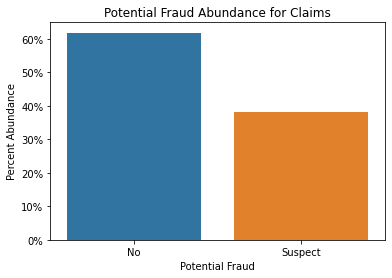

In [82]:
perc_claims    = pd.DataFrame(claims.PotentialFraud.value_counts()/claims.shape[0])
perc_providers = pd.DataFrame(data_dict['Train'].PotentialFraud.value_counts()/data_dict['Train'].shape[0])

plot = sns.barplot(x = perc_claims.index.values, y = perc_claims.PotentialFraud)

plot.set_yticklabels(["{}%".format(x) for x in range(0,70,10)])
plot.set_xticklabels(["No","Suspect"])
plot.set_ylabel("Percent Abundance")
plot.set_xlabel("Potential Fraud")
plot.set_title("Potential Fraud Abundance for Claims")

plt.savefig("./graphics/perc_claims.png")


<ipython-input-83-bd2ce8688ce7>:3: UserWarning: FixedFormatter should only be used together with FixedLocator
  plot2.set_yticklabels(["{}%".format(x) for x in range(0,90,20)])


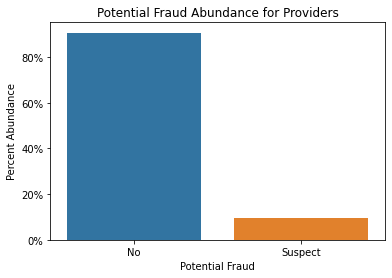

In [83]:
plot2 = sns.barplot(x = perc_providers.index.values, y = perc_providers.PotentialFraud)

plot2.set_yticklabels(["{}%".format(x) for x in range(0,90,20)])
plot2.set_xticklabels(["No","Suspect"])
plot2.set_ylabel("Percent Abundance")
plot2.set_xlabel("Potential Fraud")
plot2.set_title("Potential Fraud Abundance for Providers")

plt.savefig('./graphics/perc_providers.png')

In [83]:
data_dict['Train_Beneficiarydata'].head()

,BeneID,DOB,DOD,Gender,Race,RenalDiseaseIndicator,State,County,NoOfMonths_PartACov,NoOfMonths_PartBCov,...,ChronicCond_Depression,ChronicCond_Diabetes,ChronicCond_IschemicHeart,ChronicCond_Osteoporasis,ChronicCond_rheumatoidarthritis,ChronicCond_stroke,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt
0,BENE11001,1943-01-01,NaN,1,1,0,39,230,12,12,...,1,1,1,2,1,1,36000,3204,60,70
1,BENE11002,1936-09-01,NaN,2,1,0,39,280,12,12,...,2,2,2,2,2,2,0,0,30,50
2,BENE11003,1936-08-01,NaN,1,1,0,52,590,12,12,...,2,2,1,2,2,2,0,0,90,40
3,BENE11004,1922-07-01,NaN,1,1,0,39,270,12,12,...,2,1,1,1,1,2,0,0,1810,760
4,BENE11005,1935-09-01,NaN,1,1,0,24,680,12,12,...,2,1,2,2,2,2,0,0,1790,1200


In [84]:
print("Beneficiary Data")
print(data_dict['Train_Beneficiarydata'].shape)
print("-"*30)
print("Number of unique Beneficiary ID: {}\n".format(data_dict['Train_Beneficiarydata'].BeneID.nunique()))
print( "Most columns are condition flags: \n{}".format(data_dict['Train_Beneficiarydata'].columns.values))

Beneficiary Data
(138556, 25)
------------------------------
Number of unique Beneficiary ID: 138556

Most columns are condition flags: 
['BeneID' 'DOB' 'DOD' 'Gender' 'Race' 'RenalDiseaseIndicator' 'State'
 'County' 'NoOfMonths_PartACov' 'NoOfMonths_PartBCov'
 'ChronicCond_Alzheimer' 'ChronicCond_Heartfailure'
 'ChronicCond_KidneyDisease' 'ChronicCond_Cancer'
 'ChronicCond_ObstrPulmonary' 'ChronicCond_Depression'
 'ChronicCond_Diabetes' 'ChronicCond_IschemicHeart'
 'ChronicCond_Osteoporasis' 'ChronicCond_rheumatoidarthritis'
 'ChronicCond_stroke' 'IPAnnualReimbursementAmt' 'IPAnnualDeductibleAmt'
 'OPAnnualReimbursementAmt' 'OPAnnualDeductibleAmt']


In [85]:
data_dict['Train_Inpatientdata']

,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,AdmissionDt,...,ClmDiagnosisCode_8,ClmDiagnosisCode_9,ClmDiagnosisCode_10,ClmProcedureCode_1,ClmProcedureCode_2,ClmProcedureCode_3,ClmProcedureCode_4,ClmProcedureCode_5,ClmProcedureCode_6,Source
0,BENE11001,CLM46614,2009-04-12,2009-04-18,PRV55912,26000,PHY390922,NaN,NaN,2009-04-12,...,19889,5849,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Inpatient
1,BENE11001,CLM66048,2009-08-31,2009-09-02,PRV55907,5000,PHY318495,PHY318495,NaN,2009-08-31,...,NaN,NaN,NaN,7092.0,NaN,NaN,NaN,NaN,NaN,Inpatient
2,BENE11001,CLM68358,2009-09-17,2009-09-20,PRV56046,5000,PHY372395,NaN,PHY324689,2009-09-17,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Inpatient
3,BENE11011,CLM38412,2009-02-14,2009-02-22,PRV52405,5000,PHY369659,PHY392961,PHY349768,2009-02-14,...,40390,4019,NaN,331.0,NaN,NaN,NaN,NaN,NaN,Inpatient
4,BENE11014,CLM63689,2009-08-13,2009-08-30,PRV56614,10000,PHY379376,PHY398258,NaN,2009-08-13,...,29620,20300,NaN,3893.0,NaN,NaN,NaN,NaN,NaN,Inpatient
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40469,BENE159167,CLM69886,2009-09-28,2009-10-02,PRV53671,7000,PHY345332,PHY319565,NaN,2009-09-28,...,70704,2869,4148,9904.0,NaN,NaN,NaN,NaN,NaN,Inpatient
40470,BENE159175,CLM74504,2009-11-03,2009-11-06,PRV54981,4000,PHY342806,PHY365497,NaN,2009-11-03,...,4254,5990,NaN,8605.0,NaN,NaN,NaN,NaN,NaN,Inpatient
40471,BENE159177,CLM76485,2009-11-18,2009-11-22,PRV56588,3000,PHY423220,PHY332752,NaN,2009-11-18,...,71590,V4502,NaN,9390.0,NaN,NaN,NaN,NaN,NaN,Inpatient
40472,BENE159177,CLM79949,2009-12-17,2009-12-18,PRV56575,5000,PHY353156,NaN,NaN,2009-12-17,...,0414,41400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Inpatient


In [86]:
print("Inpatient Data")
print(data_dict['Train_Inpatientdata'].shape)
print("-"*30)
print("Number of unique ClaimID ID: {}\n".format(data_dict['Train_Inpatientdata'].ClaimID.nunique()))
print("Most columns are diagnosis, not pivoted, flags: \n{}".format(data_dict['Train_Inpatientdata'].columns.values))

Inpatient Data
(40474, 31)
------------------------------
Number of unique ClaimID ID: 40474

Most columns are diagnosis, not pivoted, flags: 
['BeneID' 'ClaimID' 'ClaimStartDt' 'ClaimEndDt' 'Provider'
 'InscClaimAmtReimbursed' 'AttendingPhysician' 'OperatingPhysician'
 'OtherPhysician' 'AdmissionDt' 'ClmAdmitDiagnosisCode'
 'DeductibleAmtPaid' 'DischargeDt' 'DiagnosisGroupCode'
 'ClmDiagnosisCode_1' 'ClmDiagnosisCode_2' 'ClmDiagnosisCode_3'
 'ClmDiagnosisCode_4' 'ClmDiagnosisCode_5' 'ClmDiagnosisCode_6'
 'ClmDiagnosisCode_7' 'ClmDiagnosisCode_8' 'ClmDiagnosisCode_9'
 'ClmDiagnosisCode_10' 'ClmProcedureCode_1' 'ClmProcedureCode_2'
 'ClmProcedureCode_3' 'ClmProcedureCode_4' 'ClmProcedureCode_5'
 'ClmProcedureCode_6' 'Source']


In [87]:
data_dict['Train_Outpatientdata']

,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,ClmDiagnosisCode_1,...,ClmDiagnosisCode_10,ClmProcedureCode_1,ClmProcedureCode_2,ClmProcedureCode_3,ClmProcedureCode_4,ClmProcedureCode_5,ClmProcedureCode_6,DeductibleAmtPaid,ClmAdmitDiagnosisCode,Source
0,BENE11002,CLM624349,2009-10-11,2009-10-11,PRV56011,30,PHY326117,NaN,NaN,78943,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,56409,Outpatient
1,BENE11003,CLM189947,2009-02-12,2009-02-12,PRV57610,80,PHY362868,NaN,NaN,6115,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,79380,Outpatient
2,BENE11003,CLM438021,2009-06-27,2009-06-27,PRV57595,10,PHY328821,NaN,NaN,2723,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,Outpatient
3,BENE11004,CLM121801,2009-01-06,2009-01-06,PRV56011,40,PHY334319,NaN,NaN,71988,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,Outpatient
4,BENE11004,CLM150998,2009-01-22,2009-01-22,PRV56011,200,PHY403831,NaN,NaN,82382,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,71947,Outpatient
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
517732,BENE159198,CLM510792,2009-08-06,2009-08-06,PRV53699,800,PHY364188,PHY364188,PHY385752,2163,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,Outpatient
517733,BENE159198,CLM551294,2009-08-29,2009-08-29,PRV53702,400,PHY423019,PHY332284,NaN,07041,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,Outpatient
517734,BENE159198,CLM596444,2009-09-24,2009-09-24,PRV53676,60,PHY361063,NaN,NaN,V570,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,Outpatient
517735,BENE159198,CLM636992,2009-10-18,2009-10-18,PRV53689,70,PHY403198,NaN,PHY419379,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,Outpatient


In [4]:
print("Outpatient Data")
print(data_dict['Train_Outpatientdata'].shape)
print("-"*30)
print("Number of unique ClaimID ID: {}\n".format(data_dict['Train_Outpatientdata'].ClaimID.nunique()))
print("Most columns are diagnosis, not pivoted, flags: \n{}".format(data_dict['Train_Outpatientdata'].columns.values))

Outpatient Data
(517737, 27)
------------------------------
Number of unique ClaimID ID: 517737

Most columns are diagnosis, not pivoted, flags: 
['BeneID' 'ClaimID' 'ClaimStartDt' 'ClaimEndDt' 'Provider'
 'InscClaimAmtReimbursed' 'AttendingPhysician' 'OperatingPhysician'
 'OtherPhysician' 'ClmDiagnosisCode_1' 'ClmDiagnosisCode_2'
 'ClmDiagnosisCode_3' 'ClmDiagnosisCode_4' 'ClmDiagnosisCode_5'
 'ClmDiagnosisCode_6' 'ClmDiagnosisCode_7' 'ClmDiagnosisCode_8'
 'ClmDiagnosisCode_9' 'ClmDiagnosisCode_10' 'ClmProcedureCode_1'
 'ClmProcedureCode_2' 'ClmProcedureCode_3' 'ClmProcedureCode_4'
 'ClmProcedureCode_5' 'ClmProcedureCode_6' 'DeductibleAmtPaid'
 'ClmAdmitDiagnosisCode']


Since inpatent and outpatient are mostly the same, we should determine if they are suitable to be combined.

In [89]:
inpat = set(data_dict['Train_Inpatientdata'].columns.values)
outpat = set(data_dict['Train_Outpatientdata'].columns.values)
print("Columns in Inpatient, not in Outpatient: {}".format(inpat.symmetric_difference(outpat)))

Columns in Inpatient, not in Outpatient: {'DischargeDt', 'DiagnosisGroupCode', 'AdmissionDt'}


In [3]:
dfs = [data_dict['Train_Inpatientdata'],data_dict['Train_Outpatientdata']]
keys = ['Inpatient',"Outpatient"]
Train_Patientdata = pd.concat([df.assign(Source=key).reset_index() for key, df in zip(keys,dfs)],axis=0, ignore_index=True).drop('index',axis=1)
Train_Patientdata.Source.value_counts()

Outpatient    517737
Inpatient      40474
Name: Source, dtype: int64

What do DiagnosisCodes look like? Are there different codes between Inpatient and outpatient?

In [5]:
inpatient_diag_codes = set(Train_Patientdata \
                                 .loc[Train_Patientdata['Source']=='Inpatient'] \
                                 .filter(like = 'ClmDiagnosisCode_') \
                                 .astype(str).to_numpy().flatten())
outpatient_diag_codes = set(Train_Patientdata \
                                  .loc[Train_Patientdata['Source']=='Outpatient'] \
                                  .filter(like = 'ClmDiagnosisCode_') \
                                  .astype(str).to_numpy().flatten())

print("There are {} unique diagnositic codes across both sets including NA" \
      .format(len(inpatient_diag_codes.union(outpatient_diag_codes))))

print("There are {} total inpatient diagnositic codes including NA." \
      .format(len(inpatient_diag_codes)))
print("There are {} total outpatient diagnositic codes including NA." \
      .format(len(outpatient_diag_codes)))



print("There are {} codes unique to Inpatient" \
      .format(len(inpatient_diag_codes.difference(outpatient_diag_codes))))
print("There are {} codes unique to Outpatient" \
      .format(len(outpatient_diag_codes.difference(inpatient_diag_codes))))
print("There are {} shared codes" \
      .format(len(outpatient_diag_codes.intersection(inpatient_diag_codes))))


There are 11015 unique diagnositic codes across both sets including NA
There are 4717 total inpatient diagnositic codes including NA.
There are 10847 total outpatient diagnositic codes including NA.
There are 168 codes unique to Inpatient
There are 6298 codes unique to Outpatient
There are 4549 shared codes


Inpatients claims show a linear increase from 0 to 10 diagnositic codes, there appears to be an extremely large discontinutity at 9 diagnositc codes. Perhaps this has to do with the data collection method?

Note: There are an order of magnitude more outpatient claims than inpatient claims.

array([<AxesSubplot:title={'center':'Inpatient'}>,
       <AxesSubplot:title={'center':'Outpatient'}>], dtype=object)

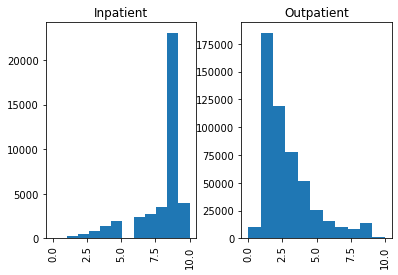

In [23]:
Train_Patientdata \
    .filter(like ="ClmDiagnosisCode_") \
    .count(axis=1) \
    .hist(by=Train_Patientdata["Source"], sharex=True,bins = 11)


Most inpatient claims have 0-2 procedure codes, almost all outpatient claims have 0, which is expected given that they are outpatients.

Note: There are an order of magnitude more outpatient claims than inpatient claims.

In [ ]:
Train_Patientdata \
    .filter(like ="ClmDiagnosisCode_") \
    .count(axis=1) \
    .hist(by=Train_Patientdata["Source"], sharex=True,bins = 11)


In [33]:
inpatient_proced_codes = set(Train_Patientdata \
                                 .loc[Train_Patientdata['Source']=='Inpatient'] \
                                 .filter(like = 'ClmProcedureCode') \
                                 .astype(str).to_numpy().flatten())
outpatient_proced_codes = set(Train_Patientdata \
                                  .loc[Train_Patientdata['Source']=='Outpatient'] \
                                  .filter(like = 'ClmProcedureCode') \
                                  .astype(str).to_numpy().flatten())

print("There are {} unique Procedure codes across both sets including NA" \
      .format(len(inpatient_proced_codes.union(outpatient_proced_codes))))

print("There are {} total inpatient Procedure codes including NA." \
      .format(len(inpatient_proced_codes)))
print("There are {} total outpatient Procedure codes including NA." \
      .format(len(outpatient_proced_codes)))



print("There are {} codes unique to Inpatient" \
      .format(len(inpatient_proced_codes.difference(outpatient_proced_codes))))
print("There are {} codes unique to Outpatient" \
      .format(len(outpatient_proced_codes.difference(inpatient_proced_codes))))
print("There are {} shared codes" \
      .format(len(outpatient_proced_codes.intersection(inpatient_proced_codes))))

There are 1325 unique Procedure codes across both sets including NA
There are 1322 total inpatient Procedure codes including NA.
There are 105 total outpatient Procedure codes including NA.
There are 1220 codes unique to Inpatient
There are 3 codes unique to Outpatient
There are 102 shared codes


array([<AxesSubplot:title={'center':'Inpatient'}>,
       <AxesSubplot:title={'center':'Outpatient'}>], dtype=object)

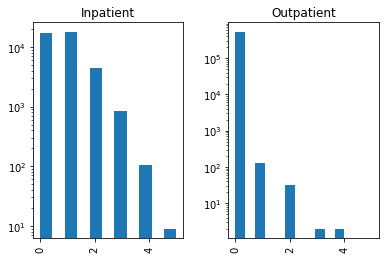

In [25]:
Train_Patientdata \
    .filter(like ="ClmProcedureCode") \
    .count(axis=1) \
    .hist(by=Train_Patientdata["Source"], sharex=True,bins = 11, log = True)


In [119]:
! pip show seaborn 

Name: seaborn
Version: 0.11.2
Summary: seaborn: statistical data visualization
Home-page: https://seaborn.pydata.org
Author: Michael Waskom
Author-email: mwaskom@gmail.com
License: BSD (3-clause)
Location: c:\users\james\anaconda3\lib\site-packages
Requires: matplotlib, scipy, numpy, pandas
Required-by: missingno


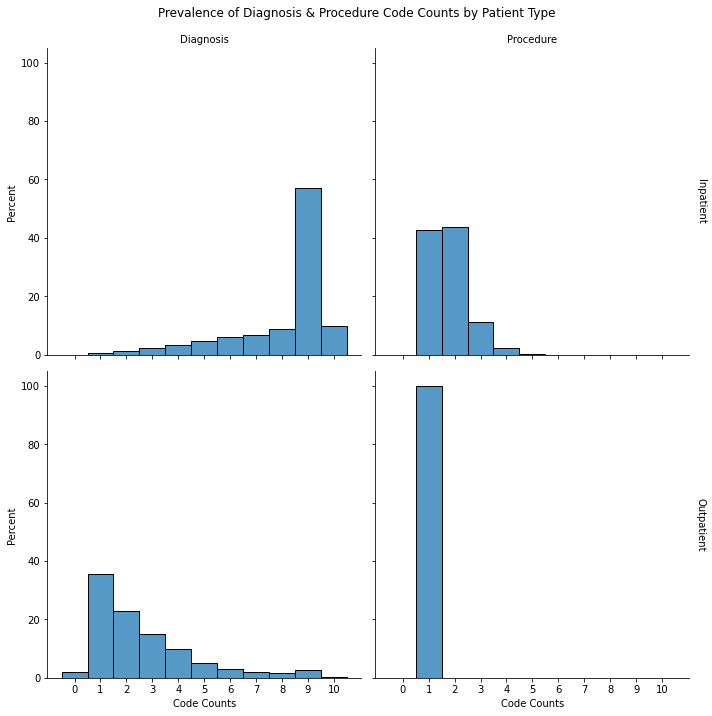

In [88]:
data = Train_Patientdata

data['Diagnosis'] = data.filter(like='ClmDiagnosis').count(axis=1)
data['Procedure'] = data.filter(like='Procedure').count(axis=1)

data = pd.melt(data, id_vars=['Source'],
               value_vars=['Diagnosis','Procedure'],
               value_name='Code Counts',var_name='Code Type')

p = sns.displot(data = data,
           x = 'Code Counts',
           col = 'Code Type',
           row = 'Source',
           kind = 'hist',
            discrete= True,
           facet_kws = dict(sharey=True,margin_titles=True),
               stat='percent',
                common_norm =False
               )

p.set_titles(col_template="{col_name}", row_template='{row_name}')
p.set(xticks=range(0,11))
p.fig.suptitle("Prevalence of Diagnosis & Procedure Code Counts by Patient Type", y=.99)
p.tight_layout()

p.savefig('./graphics/diag_proced_codecounts.png')

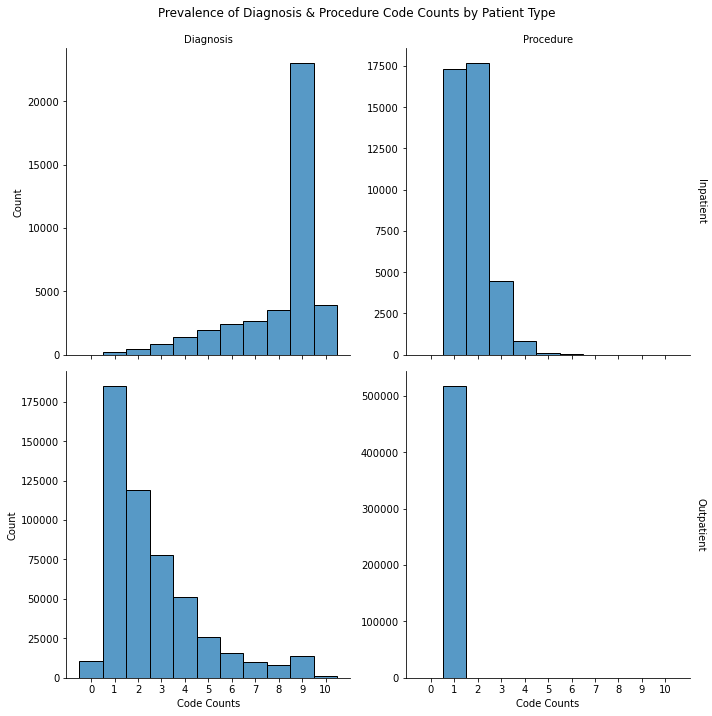

In [90]:
data = Train_Patientdata

data['Diagnosis'] = data.filter(like='ClmDiagnosis').count(axis=1)
data['Procedure'] = data.filter(like='Procedure').count(axis=1)

data = pd.melt(data, id_vars=['Source'],
               value_vars=['Diagnosis','Procedure'],
               value_name='Code Counts',var_name='Code Type')

p = sns.displot(data = data,
           x = 'Code Counts',
           col = 'Code Type',
           row = 'Source',
           kind = 'hist',
            discrete= True,
           facet_kws = dict(sharey=False,margin_titles=True),
               stat='count'
               )

p.set_titles(col_template="{col_name}", row_template='{row_name}')
p.set(xticks=range(0,11))
p.fig.suptitle("Prevalence of Diagnosis & Procedure Code Counts by Patient Type", y=.99)
p.tight_layout()

p.savefig('./graphics/diag_proced_codecounts.png')

Text(8, 0.365, 'Average Fraud')

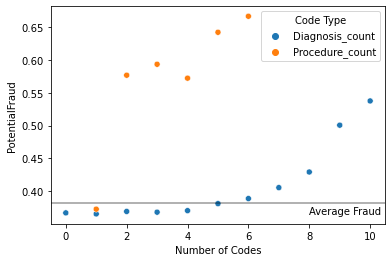

In [154]:
data = claims

data['Diagnosis_count'] = data.filter(like='ClmDiagnosis').count(axis=1)
data['Procedure_count'] = data.filter(like='Procedure').count(axis=1)

data = pd.melt(data,id_vars=['PotentialFraud'],
               value_vars=["Diagnosis_count","Procedure_count"],
              value_name="Number of Codes",var_name='Code Type')

data = data.groupby(['Code Type','Number of Codes']).agg({'PotentialFraud':'mean'}).reset_index()
sns.scatterplot(x='Number of Codes',
                y="PotentialFraud",
                data=data,
                hue="Code Type")
plt.axhline(y=claims.PotentialFraud.mean(), c='k',alpha=0.4)
plt.text(x=8,y=.365, s= "Average Fraud")


Text(87.0, 0.5, 'Number of Diagnosis Codes')

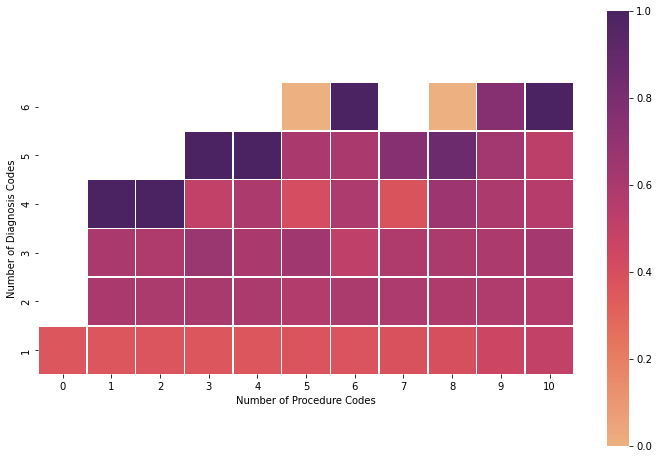

In [159]:
data = claims


data['Diagnosis_count'] = data.filter(like='ClmDiagnosis').count(axis=1)
data['Procedure_count'] = data.filter(like='Procedure').count(axis=1)

diag_proce = data.groupby(["Diagnosis_count","Procedure_count"])\
                 .agg({"PotentialFraud":'mean'}).reset_index()\
                 .pivot(index="Procedure_count",columns='Diagnosis_count',values='PotentialFraud')\
                 .sort_index(ascending=False)



plt.figure(figsize=(12,8))
plot = sns.heatmap(data =diag_proce,
           square=True,
           linewidths=0.5,
           cmap='flare')
plot.set_xlabel("Number of Procedure Codes")
plot.set_ylabel("Number of Diagnosis Codes")

In [34]:
Train_Patientdata.columns

Index(['BeneID', 'ClaimID', 'ClaimStartDt', 'ClaimEndDt', 'Provider',
       'InscClaimAmtReimbursed', 'AttendingPhysician', 'OperatingPhysician',
       'OtherPhysician', 'AdmissionDt', 'ClmAdmitDiagnosisCode',
       'DeductibleAmtPaid', 'DischargeDt', 'DiagnosisGroupCode',
       'ClmDiagnosisCode_1', 'ClmDiagnosisCode_2', 'ClmDiagnosisCode_3',
       'ClmDiagnosisCode_4', 'ClmDiagnosisCode_5', 'ClmDiagnosisCode_6',
       'ClmDiagnosisCode_7', 'ClmDiagnosisCode_8', 'ClmDiagnosisCode_9',
       'ClmDiagnosisCode_10', 'ClmProcedureCode_1', 'ClmProcedureCode_2',
       'ClmProcedureCode_3', 'ClmProcedureCode_4', 'ClmProcedureCode_5',
       'ClmProcedureCode_6', 'Source'],
      dtype='object')

In [37]:
Train_Patientdata["DiagnosisCodeCount"] = Train_Patientdata.filter(like="ClmDiagnosisCode_").count(axis=1)
Train_Patientdata["ProcedureCodeCount"] = Train_Patientdata.filter(like="ClmProcedureCode_").count(axis=1)

array([[<AxesSubplot:title={'center':'n_claims'}>,
        <AxesSubplot:title={'center':'n_provider'}>],
       [<AxesSubplot:title={'center':'avg_reimbursed'}>,
        <AxesSubplot:title={'center':'avg_deductable'}>],
       [<AxesSubplot:title={'center':'avg_diag_count'}>,
        <AxesSubplot:title={'center':'avg_prcd_count'}>]], dtype=object)

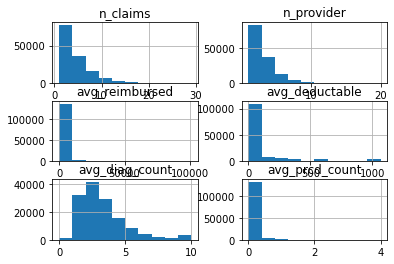

In [46]:
Train_Patientdata.groupby("BeneID").agg(n_claims = ("ClaimID","nunique"),
                                        n_provider = ("Provider","nunique"),
                                        avg_reimbursed = ("InscClaimAmtReimbursed","mean"),
                                        avg_deductable = ("DeductibleAmtPaid","mean"),
                                        avg_diag_count = ("DiagnosisCodeCount",'mean'),
                                        avg_prcd_count = ("ProcedureCodeCount",'mean')
                                       ).hist()

In [4]:
Bene_data = data_dict['Train_Beneficiarydata']

Bene_data.columns

Index(['BeneID', 'DOB', 'DOD', 'Gender', 'Race', 'RenalDiseaseIndicator',
       'State', 'County', 'NoOfMonths_PartACov', 'NoOfMonths_PartBCov',
       'ChronicCond_Alzheimer', 'ChronicCond_Heartfailure',
       'ChronicCond_KidneyDisease', 'ChronicCond_Cancer',
       'ChronicCond_ObstrPulmonary', 'ChronicCond_Depression',
       'ChronicCond_Diabetes', 'ChronicCond_IschemicHeart',
       'ChronicCond_Osteoporasis', 'ChronicCond_rheumatoidarthritis',
       'ChronicCond_stroke', 'IPAnnualReimbursementAmt',
       'IPAnnualDeductibleAmt', 'OPAnnualReimbursementAmt',
       'OPAnnualDeductibleAmt'],
      dtype='object')

In [47]:
print("There are {} patients".format(Bene_data.shape[0]))
print("{:.2f}% of patients have not died".format(100* Bene_data[Bene_data.DOD.isna()].shape[0] / Bene_data.shape[0]))


There are 138556 patients
98.97% of patients have not died


Considering the abundance and data, especially without a data dictionary, 1 appears to be the condition "present" value and 2 is the condition "absent" value. This feels intuitive since only conditions like Diabetes, IschmicHeart (clogged arteries) are more common than absent in the dataset. 

This is also consistant with more rare conditions such as cancer, depression, and ObstrPulmanary, where 2 has a higher count than 1. 

In [103]:
[Bene_data[x].value_counts(dropna=False) for x in Bene_data.filter(like="ChronicCond_").columns]

[2    92530
 1    46026
 Name: ChronicCond_Alzheimer, dtype: int64,
 2    70154
 1    68402
 Name: ChronicCond_Heartfailure, dtype: int64,
 2    95277
 1    43279
 Name: ChronicCond_KidneyDisease, dtype: int64,
 2    121935
 1     16621
 Name: ChronicCond_Cancer, dtype: int64,
 2    105697
 1     32859
 Name: ChronicCond_ObstrPulmonary, dtype: int64,
 2    89296
 1    49260
 Name: ChronicCond_Depression, dtype: int64,
 1    83391
 2    55165
 Name: ChronicCond_Diabetes, dtype: int64,
 1    93644
 2    44912
 Name: ChronicCond_IschemicHeart, dtype: int64,
 2    100497
 1     38059
 Name: ChronicCond_Osteoporasis, dtype: int64,
 2    102972
 1     35584
 Name: ChronicCond_rheumatoidarthritis, dtype: int64,
 2    127602
 1     10954
 Name: ChronicCond_stroke, dtype: int64]

Exploring association rule for chronic conditions

In [22]:
Bene_data.filter(like="ChronicCond_").head()

,ChronicCond_Alzheimer,ChronicCond_Heartfailure,ChronicCond_KidneyDisease,ChronicCond_Cancer,ChronicCond_ObstrPulmonary,ChronicCond_Depression,ChronicCond_Diabetes,ChronicCond_IschemicHeart,ChronicCond_Osteoporasis,ChronicCond_rheumatoidarthritis,ChronicCond_stroke
0,1,2,1,2,2,1,1,1,2,1,1
1,2,2,2,2,2,2,2,2,2,2,2
2,1,2,2,2,2,2,2,1,2,2,2
3,1,1,2,2,2,2,1,1,1,1,2
4,2,2,2,2,1,2,1,2,2,2,2


In [49]:
# Add renal disease indicator

chronic_conds = Bene_data.filter(like="ChronicCond_").astype(str)
chronic_conds = chronic_conds.loc[:,:] \
                             .replace("1",pd.Series(chronic_conds.columns, chronic_conds.columns)) \
                             .replace("2",np.NaN)\
                             .values.tolist()
                            
cleaned_chronic_conds = [[i for i in x if pd.isnull(i)==False] for x in chronic_conds]
cleaned_chronic_conds = [x for x in cleaned_chronic_conds if x != []]

In [57]:
association_rules = apriori.apriori(cleaned_chronic_conds, min_length=2)
                                    #, min_support=0.2, min_confidence=0.2, min_lift=2, min_length=2)
association_results = list(association_rules)

It might be more useful to make a key of diagnosis/procedures based on chronic conditions and then get the percentage prevalence for the pair.

In [75]:
claim_bene = Train_Patientdata.merge(Bene_data,on="BeneID")
claim_bene.columns

Index(['BeneID', 'ClaimID', 'ClaimStartDt', 'ClaimEndDt', 'Provider',
       'InscClaimAmtReimbursed', 'AttendingPhysician', 'OperatingPhysician',
       'OtherPhysician', 'AdmissionDt', 'ClmAdmitDiagnosisCode',
       'DeductibleAmtPaid', 'DischargeDt', 'DiagnosisGroupCode',
       'ClmDiagnosisCode_1', 'ClmDiagnosisCode_2', 'ClmDiagnosisCode_3',
       'ClmDiagnosisCode_4', 'ClmDiagnosisCode_5', 'ClmDiagnosisCode_6',
       'ClmDiagnosisCode_7', 'ClmDiagnosisCode_8', 'ClmDiagnosisCode_9',
       'ClmDiagnosisCode_10', 'ClmProcedureCode_1', 'ClmProcedureCode_2',
       'ClmProcedureCode_3', 'ClmProcedureCode_4', 'ClmProcedureCode_5',
       'ClmProcedureCode_6', 'Source', 'DOB', 'DOD', 'Gender', 'Race',
       'RenalDiseaseIndicator', 'State', 'County', 'NoOfMonths_PartACov',
       'NoOfMonths_PartBCov', 'ChronicCond_Alzheimer',
       'ChronicCond_Heartfailure', 'ChronicCond_KidneyDisease',
       'ChronicCond_Cancer', 'ChronicCond_ObstrPulmonary',
       'ChronicCond_Depression', '

In [94]:
filter_cols = ['ClmDiagnosisCode_1', 'ClmDiagnosisCode_2', 'ClmDiagnosisCode_3',
       'ClmDiagnosisCode_4', 'ClmDiagnosisCode_5', 'ClmDiagnosisCode_6',
       'ClmDiagnosisCode_7', 'ClmDiagnosisCode_8', 'ClmDiagnosisCode_9',
       'ClmDiagnosisCode_10', 'ClmProcedureCode_1', 'ClmProcedureCode_2',
       'ClmProcedureCode_3', 'ClmProcedureCode_4', 'ClmProcedureCode_5',
       'ClmProcedureCode_6','RenalDiseaseIndicator','ChronicCond_Alzheimer',
       'ChronicCond_Heartfailure', 'ChronicCond_KidneyDisease',
       'ChronicCond_Cancer', 'ChronicCond_ObstrPulmonary',
       'ChronicCond_Depression', 'ChronicCond_Diabetes',
       'ChronicCond_IschemicHeart', 'ChronicCond_Osteoporasis',
       'ChronicCond_rheumatoidarthritis', 'ChronicCond_stroke']

renamed_cols = ['RenalDiseaseIndicator','ChronicCond_Alzheimer',
       'ChronicCond_Heartfailure', 'ChronicCond_KidneyDisease',
       'ChronicCond_Cancer', 'ChronicCond_ObstrPulmonary',
       'ChronicCond_Depression', 'ChronicCond_Diabetes',
       'ChronicCond_IschemicHeart', 'ChronicCond_Osteoporasis',
       'ChronicCond_rheumatoidarthritis', 'ChronicCond_stroke']


prevalence_lookup = claim_bene.filter(filter_cols, axis=1)

prevalence_lookup


prevalence_lookup = prevalence_lookup.loc[:,:] \
                             .replace(1,pd.Series(prevalence_lookup.columns, prevalence_lookup.columns)) \
                             .replace(2,np.NaN)

pd.melt()


,ClmDiagnosisCode_1,ClmDiagnosisCode_2,ClmDiagnosisCode_3,ClmDiagnosisCode_4,ClmDiagnosisCode_5,ClmDiagnosisCode_6,ClmDiagnosisCode_7,ClmDiagnosisCode_8,ClmDiagnosisCode_9,ClmDiagnosisCode_10,...,ChronicCond_Heartfailure,ChronicCond_KidneyDisease,ChronicCond_Cancer,ChronicCond_ObstrPulmonary,ChronicCond_Depression,ChronicCond_Diabetes,ChronicCond_IschemicHeart,ChronicCond_Osteoporasis,ChronicCond_rheumatoidarthritis,ChronicCond_stroke
0,1970,4019,5853,7843,2768,71590,2724,19889,5849,NaN,...,NaN,ChronicCond_KidneyDisease,NaN,NaN,ChronicCond_Depression,ChronicCond_Diabetes,ChronicCond_IschemicHeart,NaN,ChronicCond_rheumatoidarthritis,ChronicCond_stroke
1,6186,2948,56400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,ChronicCond_KidneyDisease,NaN,NaN,ChronicCond_Depression,ChronicCond_Diabetes,ChronicCond_IschemicHeart,NaN,ChronicCond_rheumatoidarthritis,ChronicCond_stroke
2,29623,30390,71690,34590,V1581,32723,NaN,NaN,NaN,NaN,...,NaN,ChronicCond_KidneyDisease,NaN,NaN,ChronicCond_Depression,ChronicCond_Diabetes,ChronicCond_IschemicHeart,NaN,ChronicCond_rheumatoidarthritis,ChronicCond_stroke
3,43491,2762,7843,32723,V1041,4254,25062,40390,4019,NaN,...,ChronicCond_Heartfailure,ChronicCond_KidneyDisease,NaN,NaN,ChronicCond_Depression,ChronicCond_Diabetes,NaN,NaN,ChronicCond_rheumatoidarthritis,ChronicCond_stroke
4,78969,78701,V5866,59389,2449,NaN,NaN,NaN,NaN,NaN,...,ChronicCond_Heartfailure,ChronicCond_KidneyDisease,NaN,NaN,ChronicCond_Depression,ChronicCond_Diabetes,NaN,NaN,ChronicCond_rheumatoidarthritis,ChronicCond_stroke
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
558206,2163,V4575,53190,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,ChronicCond_Heartfailure,NaN,NaN,NaN,ChronicCond_Depression,ChronicCond_Diabetes,NaN,NaN,ChronicCond_rheumatoidarthritis,NaN
558207,07041,5781,25000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,ChronicCond_Heartfailure,NaN,NaN,NaN,ChronicCond_Depression,ChronicCond_Diabetes,NaN,NaN,ChronicCond_rheumatoidarthritis,NaN
558208,V570,78079,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,ChronicCond_Heartfailure,NaN,NaN,NaN,ChronicCond_Depression,ChronicCond_Diabetes,NaN,NaN,ChronicCond_rheumatoidarthritis,NaN
558209,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,ChronicCond_Heartfailure,NaN,NaN,NaN,ChronicCond_Depression,ChronicCond_Diabetes,NaN,NaN,ChronicCond_rheumatoidarthritis,NaN


## Date Analysis

In [76]:
date_dict = ['ClaimStartDt',"ClaimEndDt","AdmissionDt","DischargeDt",'DOB',"DOD"]
claims[date_dict] = claims[date_dict].apply(pd.to_datetime)

for x in date_dict:
    data = claims.groupby(x).agg({"PotentialFraud":"mean"})
    sns.scatterplot(data.index, data.PotentialFraud)
    plt.show()

SyntaxError: invalid syntax (<ipython-input-76-077ab31e1087>, line 2)

In [ ]:
#analyze time segment of treatment (connecting line plots. )

# IF YOU are treated by a suspect provider are you more liely to have higher codes?

array([[<AxesSubplot:title={'center':'(0, Inpatient)'}>,
        <AxesSubplot:title={'center':'(0, Outpatient)'}>],
       [<AxesSubplot:title={'center':'(1, Inpatient)'}>,
        <AxesSubplot:title={'center':'(1, Outpatient)'}>]], dtype=object)

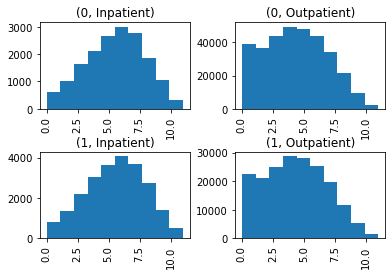

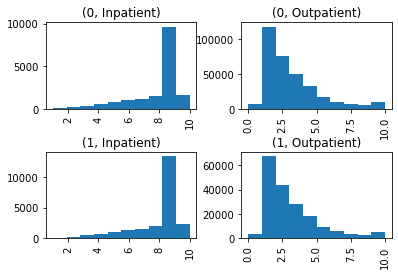

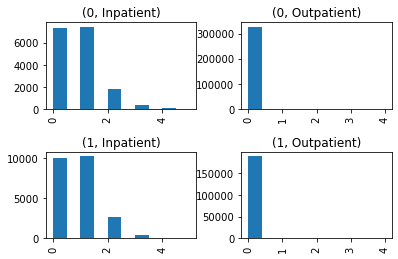

In [56]:
    chronic_cols = ['RenalDiseaseIndicator','ChronicCond_Alzheimer', 'ChronicCond_Heartfailure',
                   'ChronicCond_KidneyDisease', 'ChronicCond_Cancer',
                   'ChronicCond_ObstrPulmonary', 'ChronicCond_Depression',
                   'ChronicCond_Diabetes', 'ChronicCond_IschemicHeart',
                   'ChronicCond_Osteoporasis', 'ChronicCond_rheumatoidarthritis',
                   'ChronicCond_stroke']

# Count of Chronic conditions
    claims.filter(items = chronic_cols).sum(axis=1).hist(by=[claims.PotentialFraud,claims.Source])
    
    # Count of Diagnosis Codes
    claims.filter(like="ClmDiagnosisCode_").count(axis=1).hist(by=[claims.PotentialFraud,claims.Source])
    
    # Count of Procedure Codes
    claims.filter(like="ClmProcedureCode_").count(axis=1).hist(by=[claims.PotentialFraud,claims.Source])

In [ ]:
# Doesnt seem like it

## Some Dates just dont add up.

In [71]:
mask = claims.AdmissionDt.notna()
thing1 = claims[mask][claims[mask]['ClaimStartDt'] != claims[mask]['AdmissionDt']].filter(['ClaimStartDt','ClaimEndDt','AdmissionDt','DischargeDt','PotentialFraud'])  #.filter(['ClaimStartDt','AdmissionDt'])
thing1

,ClaimStartDt,ClaimEndDt,AdmissionDt,DischargeDt,PotentialFraud
62479,2009-02-15,2009-02-20,2009-02-04,2009-02-20,1
65458,2009-11-19,2009-12-06,2009-11-15,2009-12-06,1
82571,2009-09-13,2009-09-20,2009-09-11,2009-09-20,0
124136,2009-03-18,2009-04-08,2009-03-04,2009-04-08,1
170272,2009-04-21,2009-04-30,2009-03-26,2009-04-30,0
175538,2009-11-14,2009-11-17,2009-11-13,2009-11-17,0
190695,2009-07-16,2009-07-17,2009-07-14,2009-07-17,1
198270,2009-02-10,2009-02-11,2009-02-08,2009-02-11,1
210780,2009-04-10,2009-04-11,2009-04-09,2009-04-11,1
227723,2009-10-21,2009-10-22,2009-10-18,2009-10-22,0


In [77]:
(claims['ClaimEndDt'] != claims['DischargeDt']).value_counts()

True     517754
False     40457
dtype: int64

In [72]:
mask = claims.DischargeDt.notna()
thing2 = claims[mask][claims[mask]['ClaimEndDt'] != claims[mask]['DischargeDt']].filter(['ClaimStartDt','ClaimEndDt','AdmissionDt','DischargeDt','PotentialFraud','ClaimID','BeneID','Provider'])  #.filter(['ClaimStartDt','AdmissionDt'])
thing2

,ClaimStartDt,ClaimEndDt,AdmissionDt,DischargeDt,PotentialFraud,ClaimID,BeneID,Provider
18894,2009-01-03,2009-01-29,2009-01-03,2009-01-28,1,CLM82218,BENE119908,PRV57191
41957,2009-01-03,2009-01-12,2009-01-03,2009-01-09,1,CLM82202,BENE11093,PRV51842
62741,2008-12-01,2009-01-06,2008-12-01,2009-01-03,1,CLM82204,BENE156020,PRV52019
65051,2009-01-08,2009-01-12,2009-01-08,2009-01-10,1,CLM82214,BENE138446,PRV54955
65397,2009-02-09,2009-03-17,2009-02-09,2009-03-16,1,CLM82217,BENE110116,PRV56268
77470,2008-12-26,2009-01-04,2008-12-26,2009-01-03,1,CLM82206,BENE116436,PRV52178
141893,2009-02-23,2009-02-28,2009-02-23,2009-02-25,1,CLM82205,BENE88968,PRV52045
215587,2009-01-18,2009-01-27,2009-01-18,2009-01-25,1,CLM82209,BENE44545,PRV52843
268514,2009-01-17,2009-01-25,2009-01-17,2009-01-24,1,CLM82201,BENE131263,PRV51021
276700,2009-01-01,2009-01-22,2009-01-01,2009-01-19,1,CLM82216,BENE107828,PRV55018


## Medicare parts

In [94]:
#claims.groupby("NoOfMonths_PartACov").agg({'PotentialFraud':'mean'})
#claims.groupby("NoOfMonths_PartBCov").agg({'PotentialFraud':'mean'})
claims[claims.NoOfMonths_PartACov != claims.NoOfMonths_PartBCov].PotentialFraud.mean()

0.3690272373540856

C:\Users\James\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='NoOfMonths_PartBCov', ylabel='PotentialFraud'>

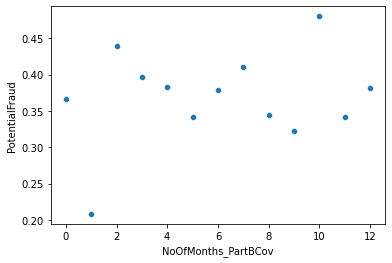

In [101]:
#data = claims.groupby("NoOfMonths_PartACov").agg({'PotentialFraud':'mean'})
data = claims.groupby("NoOfMonths_PartBCov").agg({'PotentialFraud':'mean'})

sns.scatterplot(data.index, data.PotentialFraud)

## Payments

In [75]:
pays = ['InscClaimAmtReimbursed', 'DeductibleAmtPaid',
       'IPAnnualReimbursementAmt', 'IPAnnualDeductibleAmt',
       'OPAnnualReimbursementAmt', 'OPAnnualDeductibleAmt','PotentialFraud', 'BeneID']

# Deductable: Patient pays
# Reimbursement: provider pays


# InscClaimAmtReimbursed:
#  Paid by provider for claim

# DeductibleAmtPaid
#  paid by customer?

# IPAnnualReimbursementAmt
#  could be paid by insurer?

# IPAnnualDeductibleAmt
#  patient paid for service

# OPAnnualReimbursementAmt
#  could be paid by insurer?

# OPAnnualDeductibleAmt
#  patient paid for service



# doesnt seem to be a distribution difference between fraud & amounts
#[claims[x].hist(by = claims.PotentialFraud) for x in pays]


claims.filter(pays).sort_values('BeneID')

,InscClaimAmtReimbursed,DeductibleAmtPaid,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt,PotentialFraud,BeneID
133721,70,0.0,0,0,120,30,1,BENE100000
133720,50,0.0,0,0,120,30,1,BENE100000
144964,10,0.0,0,0,2530,540,0,BENE100001
320525,70,0.0,0,0,2530,540,0,BENE100001
49569,700,100.0,0,0,2530,540,1,BENE100001
...,...,...,...,...,...,...,...,...
87099,80,0.0,0,0,1270,690,0,BENE99999
107319,30,0.0,0,0,1270,690,0,BENE99999
87329,700,0.0,0,0,1270,690,0,BENE99999
77075,60,0.0,0,0,1270,690,0,BENE99999


array([<AxesSubplot:title={'center':'0'}>,
       <AxesSubplot:title={'center':'1'}>], dtype=object)

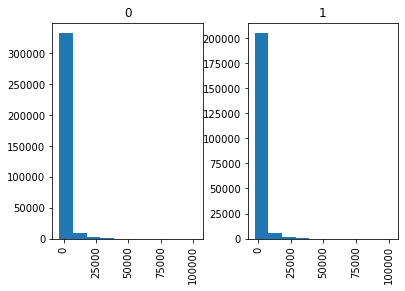

In [42]:
(claims.OPAnnualReimbursementAmt - claims.OPAnnualDeductibleAmt).hist(by=claims.PotentialFraud)

## Data Cleaning & Feature Engineering <a id='clean'></a>

[Back To Top](#top)

### [Claim group codes](https://www.cms.gov/icd10m/version38-0-R1-fullcode-cms/fullcode_cms/P0002.html)

### [Diagnosis and Procedure Codes](https://www.cms.gov/Medicare/Coding/ICD9ProviderDiagnosticCodes/codes)

In [ ]:
# claim admit diagnosis code


# Why are some admission dates before/after 

In [87]:
def claim_clean(claim_data):
    ''' cleaning the combined claims (inpatient, outpatient, provider, and beneficiary)
    imputing nulls, shifting some of the values. 
    
    
    '''
    chronic_cols = ['RenalDiseaseIndicator','ChronicCond_Alzheimer', 'ChronicCond_Heartfailure',
                   'ChronicCond_KidneyDisease', 'ChronicCond_Cancer',
                   'ChronicCond_ObstrPulmonary', 'ChronicCond_Depression',
                   'ChronicCond_Diabetes', 'ChronicCond_IschemicHeart',
                   'ChronicCond_Osteoporasis', 'ChronicCond_rheumatoidarthritis',
                   'ChronicCond_stroke']
    
    #Replace Chronic Diseases & Renal Indicator with 0/1 notation.
    claim_data[chronic_cols] = claim_data.filter(chronic_cols).replace({2:0,"Y":1})
    # IS THIS THE RIGHT CHOICE?
    
    
    # Shifting gender to 0/1 instead of 1/2
    claim_data["Gender"] = claim_data["Gender"] - 1
    
    
    # Changing Source to 0/1 with rename
    claim_data['Source_Inpatient'] = claim_data.Source.replace({"Outpatient":0,"Inpatient":1})
    #claim_data                     = claim_data.drop('Source')
    
    return(claim_data)
    
    
def feat_eng(claim_data, dummify = False):
    chronic_cols = ['RenalDiseaseIndicator','ChronicCond_Alzheimer', 'ChronicCond_Heartfailure',
                   'ChronicCond_KidneyDisease', 'ChronicCond_Cancer',
                   'ChronicCond_ObstrPulmonary', 'ChronicCond_Depression',
                   'ChronicCond_Diabetes', 'ChronicCond_IschemicHeart',
                   'ChronicCond_Osteoporasis', 'ChronicCond_rheumatoidarthritis',
                   'ChronicCond_stroke']
    
    # age, dates dropped below
    claim_data['age_infered'] = ((pd.to_datetime(claim_data['DOD']).max() - pd.to_datetime(claim_data["DOB"])).dt.days / 365)
    
    # Death Flag, dates dropped below
    claim_data['death_flag'] = claim_data['DOD'].isnull().astype(int)
    
    
    # Count of Chronic conditions
    claim_data['chronic_count'] = claim_data.filter(items = chronic_cols).sum(axis=1)
    
    # Count of Diagnosis Codes
    claim_data['diagnosis_count'] = claim_data.filter(like="ClmDiagnosisCode_").count(axis=1)
    
    # Count of Procedure Codes
    claim_data['procedure_count'] = claim_data.filter(like="ClmProcedureCode_").count(axis=1)
    
    # Length of claim
    claim_data['claim_length'] = (pd.to_datetime(claim_data['ClaimEndDt']) - pd.to_datetime(claim_data['ClaimStartDt'])).dt.days
    
    
    # Impute nan in admission/discharge columns. Our source column is dealing with 
    claim_data['AdmissionDt'] = claim_data['AdmissionDt'].fillna(claim_data['ClaimStartDt'])
    claim_data['DischargeDt'] = claim_data['DischargeDt'].fillna(claim_data['ClaimEndDt'])
    
    # Difference (flag and value) between claim start/admission and end/discharge
    claim_data['Admission_not_start'] = claim_data['ClaimStartDt'] != claim_data['AdmissionDt'] 
    claim_data['Discharge_not_end']   = claim_data['ClaimEndDt'] != claim_data['DischargeDt']
    claim_data['Start_Dt_discrepency'] = claim_data['ClaimStartDt'] - claim_data['AdmissionDt']
    claim_data['Start_Dt_discrepency'] = claim_data['ClaimEndDt'] - claim_data['DischargeDt']
    
    # Droping dates due to modeling issues 
    claim_data = claim_data.drop(['ClaimStartDt','ClaimEndDt'], axis = 1)
    claim_data = claim_data.drop(['DOB','DOD'],                 axis = 1)
    claim_data = claim_data.drop(['AdmissionDt','DischargeDt'], axis = 1)
    

    # Missing Physicians
    claim_data['phys_num']          = claim_data.filter(like='Physician').count(axis=1)
    claim_data['phys_no_attending'] = claim_data["AttendingPhysician"].isna().astype(int)
    claim_data['phys_no_operating'] = claim_data["OperatingPhysician"].isna().astype(int)
    claim_data['phys_no_other']     = claim_data['OtherPhysician'].isna().astype(int)
    
    
    if (dummify):
        for x in ["Race","State","County"]:
            claim_data[x] = pd.get_dummies(claim_data[x], prefix=x)
    
    return(claim_data)

    
def drop_identifiers(data):
    dropped_data = data.drop(labels = ['BeneID','ClaimID','Provider','PotentialFraud'], axis =1) 
    target = data['PotentialFraud']
    return (dropped_data, target)

def drop_codes(data):
    code_cols = data.filter(like="Code").columns
    return data.drop(code_cols, axis=1)


# Data Prep <a id='prep'></a>

[Back To Top](#top)

In [30]:
def data_prep(to_prep):
    cleaned = claim_clean(to_prep)
    lin_eng = feat_eng(cleaned, dummify=True)
    tre_eng = feat_eng(cleaned, dummify=False)
    
    line_c_drop = drop_codes(lin_eng)
    tree_c_drop = drop_codes(tre_eng)
    
    linear, target =  drop_identifiers(line_c_drop)
    tree, target   =  drop_identifiers(tree_c_drop)

    return (linear, tree, target)



linear_prepped, tree_prepped, target =  data_prep(claims)

Index(['BeneID', 'ClaimID', 'ClaimStartDt', 'ClaimEndDt', 'Provider',
       'InscClaimAmtReimbursed', 'AttendingPhysician', 'OperatingPhysician',
       'OtherPhysician', 'AdmissionDt', 'ClmAdmitDiagnosisCode',
       'DeductibleAmtPaid', 'DischargeDt', 'DiagnosisGroupCode',
       'ClmDiagnosisCode_1', 'ClmDiagnosisCode_2', 'ClmDiagnosisCode_3',
       'ClmDiagnosisCode_4', 'ClmDiagnosisCode_5', 'ClmDiagnosisCode_6',
       'ClmDiagnosisCode_7', 'ClmDiagnosisCode_8', 'ClmDiagnosisCode_9',
       'ClmDiagnosisCode_10', 'ClmProcedureCode_1', 'ClmProcedureCode_2',
       'ClmProcedureCode_3', 'ClmProcedureCode_4', 'ClmProcedureCode_5',
       'ClmProcedureCode_6', 'Source', 'Gender', 'Race',
       'RenalDiseaseIndicator', 'State', 'County', 'NoOfMonths_PartACov',
       'NoOfMonths_PartBCov', 'ChronicCond_Alzheimer',
       'ChronicCond_Heartfailure', 'ChronicCond_KidneyDisease',
       'ChronicCond_Cancer', 'ChronicCond_ObstrPulmonary',
       'ChronicCond_Depression', 'ChronicCond_Di

In [31]:
linear_prepped

,ClaimStartDt,ClaimEndDt,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,AdmissionDt,DeductibleAmtPaid,DischargeDt,Source,...,chronic_count,diagnosis_count,procedure_count,claim_length,Admission_not_start,Discharge_not_end,phys_num,phys_no_attending,phys_no_operating,phys_no_other
0,2009-04-12,2009-04-18,26000,PHY390922,NaN,NaN,2009-04-12,1068.0,2009-04-18,Inpatient,...,7,9,0,6,False,False,1,0,1,1
1,2009-09-06,2009-09-06,50,PHY365867,PHY327147,NaN,2009-09-06,0.0,2009-09-06,Outpatient,...,4,9,0,0,False,False,2,0,0,1
2,2009-01-20,2009-02-01,19000,PHY349293,PHY370861,PHY363291,2009-01-20,1068.0,2009-02-01,Inpatient,...,5,9,2,12,False,False,3,0,0,0
3,2009-10-17,2009-11-04,17000,PHY334706,PHY334706,NaN,2009-10-17,1068.0,2009-11-04,Inpatient,...,2,9,1,18,False,False,2,0,0,1
4,2009-10-25,2009-10-29,13000,PHY390614,PHY323689,PHY363291,2009-10-25,1068.0,2009-10-29,Inpatient,...,6,7,1,4,False,False,3,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
558206,2009-06-02,2009-06-04,500,PHY317497,NaN,PHY317497,2009-06-02,0.0,2009-06-04,Outpatient,...,2,3,0,2,False,False,2,0,1,0
558207,2009-02-08,2009-02-08,3300,PHY376238,PHY376238,NaN,2009-02-08,0.0,2009-02-08,Outpatient,...,5,1,0,0,False,False,2,0,0,1
558208,2009-07-09,2009-07-29,2100,PHY338096,NaN,NaN,2009-07-09,0.0,2009-07-29,Outpatient,...,6,2,0,20,False,False,1,0,1,1
558209,2009-04-16,2009-04-16,10,PHY416646,NaN,NaN,2009-04-16,0.0,2009-04-16,Outpatient,...,9,1,0,0,False,False,1,0,1,1


# Modeling <a id='model'></a>

[Back To Top](#top)

In [58]:
from sklearn.feature_selection import SelectPercentile, SelectKBest, mutual_info_classif

from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score, StratifiedShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

#from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

In [ ]:
train_idx, test_idx = train_test_split(claims.index, test_size=0.3, stratify=)

#### Need to implement upsampling
- [SMOTE](https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/)

In [36]:
def first_pass_modeling(model, data, target):
    cv = StratifiedShuffleSplit()
    return cross_val_score(model,data,target,cv=cv, n_jobs=-1)




In [34]:
model_logit = LogisticRegression()
model_KNNC  = KNeighborsClassifier() # takes a while to run
model_SVC   = SVC()
model_RF    = RandomForestClassifier()
model_GB    = GradientBoostingClassifier()
model_XGB   = XGBClassifier()
model_MLPC  = MLPClassifier()


In [ ]:
# running weird
for model in [model_logit,model_SVC,model_RF,model_GB,model_XGB,model_MLPC]:
    print(first_pass_modeling(model,dummy_x, dummy_y))